In [1]:
%matplotlib inline
from pylab import *


In [2]:
from deficit_defs import *

Splikes version  0.1.2
Plasticnet version  0.1.6
macOS-10.16-x86_64-i386-64bit
Base Image File: asdf/bbsk081604_all_log2dog.asdf


In [3]:
def savefig(base):
    import matplotlib.pyplot as plt
    for fname in [f'Manuscript/resources/{base}.png',f'Manuscript/resources/{base}.svg']:
        print(fname)
        plt.savefig(fname, bbox_inches='tight')

In [4]:
_debug = False
if _debug:
    print("Debugging")

In [5]:
base='sims/2022-11-11'
if not os.path.exists(base):
    print(f"mkdir {base}")
    os.mkdir(base)

mkdir sims/2022-11-11


In [13]:
rf_size=19
eta=2e-6
sigma_c=1
blur=2.5
mu_c_mat=[0,13]
open_eye_noise_mat=linspace(0,1,21)
display(open_eye_noise_mat)
number_of_neurons=20
number_of_processes=4

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [19]:
base_image_file='asdf/bbsk081604_all.asdf'

In [25]:
def blur_jitter_deficit(blur=[2.5,-1],
                        noise=[0.1,.1],
                        rf_size=19,eta=2e-6,
                        mu_c=0,sigma_c=0,    
                        mu_r=0,sigma_r=0,
                        number_of_neurons=10,
                        total_time=8*day,
                        save_interval=1*hour):

    
    if _debug:
        total_time=1*minute
        save_interval=1*second
        
    images=[]
    dt=200*ms
    
    for bv in blur:
        if bv<=0:
            im=pi5.filtered_images(
                                base_image_file,
                                {'type':'log2dog','sd1':1,'sd2':3},
                                )
        else:
            im=pi5.filtered_images(
                                    base_image_file,
                                    {'type':'blur','size':bv},
                                    {'type':'log2dog','sd1':1,'sd2':3},
                                    )
        images.append(im)
        
        
    dt=200*ms        
    pre1=pn.neurons.natural_images_with_jitter(images[0],
                                                rf_size=rf_size,
                                                time_between_patterns=dt,
                                                sigma_r=0,
                                                sigma_c=0,
                                                buffer_c=mu_c+2*sigma_c,
                                                buffer_r=mu_r+2*sigma_r,
                                                verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(images[1],
                                                rf_size=rf_size,
                                                other_channel=pre1,
                                                time_between_patterns=dt,
                                                mu_r=mu_r,mu_c=mu_c,
                                                sigma_r=sigma_r,sigma_c=sigma_c,
                                                verbose=False)



    sigma=noise
    pre1+=pn.neurons.process.add_noise_normal(0,sigma)

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,sigma)

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=dt

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]


def fix_jitter(noise=0.1,rf_size=19,
           number_of_neurons=10,
            mu_c=0,sigma_c=0,    
            mu_r=0,sigma_r=0,
           total_time=8*day,
           save_interval=1*hour,
           eta=2e-6):
    
    if _debug:
        total_time=1*minute
        save_interval=1*second

    im=pi5.filtered_images(
                        base_image_file,
                        {'type':'log2dog','sd1':1,'sd2':3},
                        )
    
    dt=200*ms        
    pre1=pn.neurons.natural_images_with_jitter(im,
                                                rf_size=rf_size,
                                                time_between_patterns=dt,
                                                sigma_r=0,
                                                sigma_c=0,
                                                buffer_c=mu_c+2*sigma_c,
                                                buffer_r=mu_r+2*sigma_r,
                                                verbose=False)
    pre2=pn.neurons.natural_images_with_jitter(im,
                                                rf_size=rf_size,
                                                other_channel=pre1,
                                                time_between_patterns=dt,
                                                mu_r=mu_r,mu_c=mu_c,
                                                sigma_r=sigma_r,sigma_c=sigma_c,
                                                verbose=False)


    sigma=noise
    pre1+=pn.neurons.process.add_noise_normal(0,sigma)

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,sigma)

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    save_interval=save_interval

    sim=pn.simulation(total_time)

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]



In [26]:
def run_one(params,overwrite=False):
    import plasticnet as pn
    
    count,eta,noise,blur,number_of_neurons,sfname,mu_c,sigma_c=(params.count,params.eta,params.noise,params.blur,
                                        params.number_of_neurons,params.sfname,params.mu_c,params.sigma_c)
    
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    seq=pn.Sequence()

    t=16*day
    ts=1*hour

    # DEBUG
    if _debug:
        t=1*minute
        ts=1*second
    
    seq+=blur_jitter_deficit(blur=[blur,-1],
                                total_time=t,
                                noise=noise,eta=eta,number_of_neurons=number_of_neurons,
                                mu_c=mu_c,sigma_c=sigma_c,
                                save_interval=ts)

    t=16*hour*7*2  # two weeks
    ts=1*hour
    
    # DEBUG
    if _debug:
        t=1*minute
        ts=1*second
    
    seq+=fix_jitter(total_time=t,
           save_interval=ts,
                                mu_c=mu_c,sigma_c=sigma_c,
             eta=eta,noise=noise,number_of_neurons=number_of_neurons)

    seq.run(display_hash=False)
    pn.save(sfname,seq) 
    
    return sfname
    

In [31]:
real_time=6*60+ 29

In [35]:
from collections import namedtuple
params = namedtuple('params', ['count', 'eta','noise','blur','number_of_neurons','sfname','mu_c','sigma_c'])
all_params=[]
count=0
eta_count=0
noise_count=0
open_eye_noise=0.0

for mu_count,mu_c in enumerate(mu_c_mat):
    for noise_count,open_eye_noise in enumerate(open_eye_noise_mat):
        all_params.append(params(count=count,
                         eta=eta,
                             blur=blur,
                         noise=open_eye_noise,
                         number_of_neurons=number_of_neurons,
         sfname=f'{base}/deficit {number_of_neurons} neurons logdog {noise_count} noise {mu_c} mu_c {sigma_c} sigma_c.asdf',
                                mu_c=mu_c,sigma_c=sigma_c))
        
        count+=1
        
for a in all_params[:5]:
    print(a)
print("[....]")
for a in all_params[-5:]:
    print(a)

print(len(all_params))

print(time2str(real_time*len(all_params)/number_of_processes))


params(count=0, eta=2e-06, noise=0.0, blur=2.5, number_of_neurons=20, sfname='sims/2022-11-11/deficit 20 neurons logdog 0 noise 0 mu_c 1 sigma_c.asdf', mu_c=0, sigma_c=1)
params(count=1, eta=2e-06, noise=0.05, blur=2.5, number_of_neurons=20, sfname='sims/2022-11-11/deficit 20 neurons logdog 1 noise 0 mu_c 1 sigma_c.asdf', mu_c=0, sigma_c=1)
params(count=2, eta=2e-06, noise=0.1, blur=2.5, number_of_neurons=20, sfname='sims/2022-11-11/deficit 20 neurons logdog 2 noise 0 mu_c 1 sigma_c.asdf', mu_c=0, sigma_c=1)
params(count=3, eta=2e-06, noise=0.15000000000000002, blur=2.5, number_of_neurons=20, sfname='sims/2022-11-11/deficit 20 neurons logdog 3 noise 0 mu_c 1 sigma_c.asdf', mu_c=0, sigma_c=1)
params(count=4, eta=2e-06, noise=0.2, blur=2.5, number_of_neurons=20, sfname='sims/2022-11-11/deficit 20 neurons logdog 4 noise 0 mu_c 1 sigma_c.asdf', mu_c=0, sigma_c=1)
[....]
params(count=37, eta=2e-06, noise=0.8, blur=2.5, number_of_neurons=20, sfname='sims/2022-11-11/deficit 20 neurons logdog 

In [36]:
do_params=make_do_params(all_params)
len(do_params)

42

In [ ]:
%%time
if do_params:
    run_one(do_params[0],overwrite=True)

In [37]:
if do_params:
    pool = Pool(processes=number_of_processes)
    result = pool.map_async(run_one, do_params)
    print(result.get())

Using cache_images/cache_images_bfccd490ea9947384e0a7d994f955e3c.asdf from cache.Using cache_images/cache_images_bfccd490ea9947384e0a7d994f955e3c.asdf from cache.Using cache_images/cache_images_bfccd490ea9947384e0a7d994f955e3c.asdf from cache.Using cache_images/cache_images_bfccd490ea9947384e0a7d994f955e3c.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[[[[.....] Sequence Time Ela

In [39]:
RR={}
count=0
for mu_count,mu_c in tqdm(enumerate(mu_c_mat)):
    for noise_count,open_eye_noise in enumerate(open_eye_noise_mat):
        params=all_params[count]
        count+=1
        RR[params.sfname]=Results(params.sfname)

0it [00:00, ?it/s]

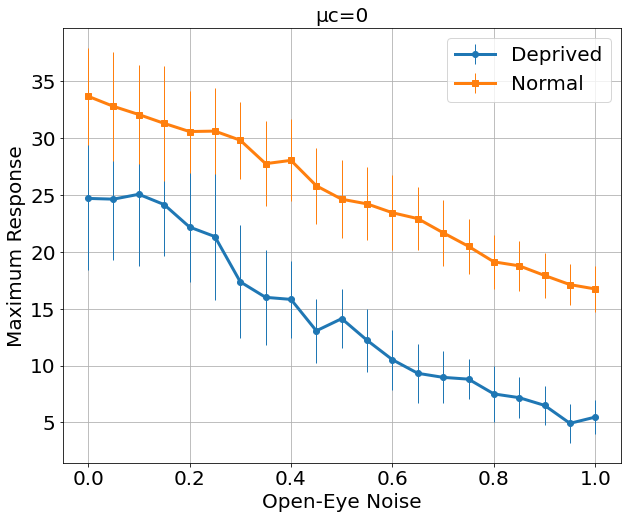

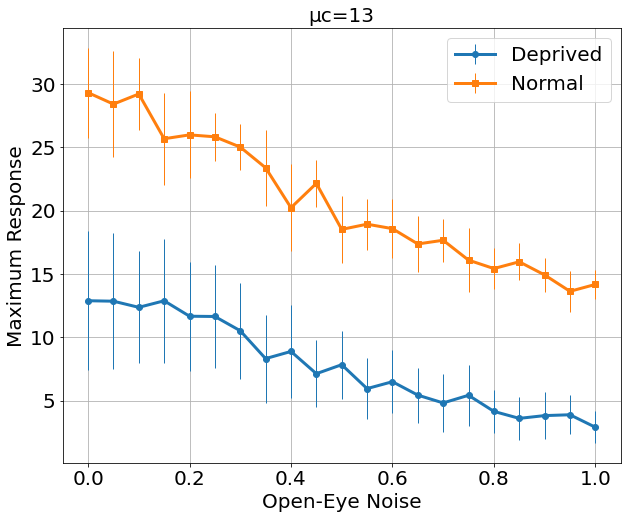

In [40]:
count=0
for mu_count,mu_c in enumerate(mu_c_mat):
    s=Storage()
    for noise_count,open_eye_noise in enumerate(open_eye_noise_mat):
        params=all_params[count]
        count+=1

        R=RR[params.sfname]
        noise=params.noise
        μ1,μ2=R.μσ[0][0]
        σ1,σ2=R.μσ[1][0]

        s+=noise,μ1,μ2,σ1,σ2
        
        
    noise,μ1,μ2,σ1,σ2=s.arrays()
    
    figure()
    errorbar(noise,μ1,yerr=2*σ1,marker='o',elinewidth=1,label='Deprived')
    errorbar(noise,μ2,yerr=2*σ2,marker='s',elinewidth=1,label='Normal')
    xlabel('Open-Eye Noise')
    ylabel('Maximum Response')
    title(f'μc={mu_c}')
    legend()            

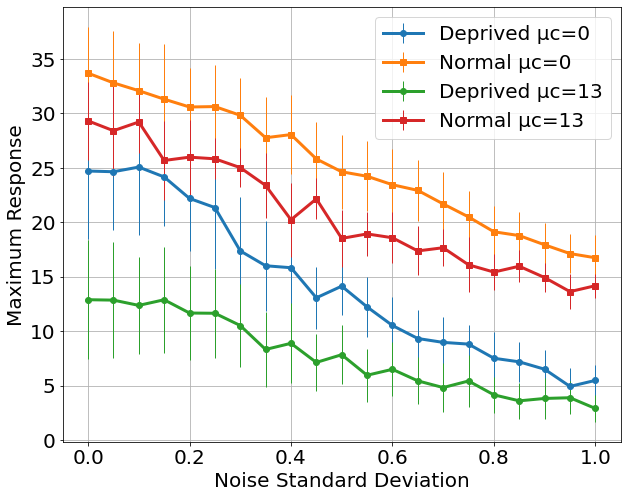

In [41]:
count=0
for mu_count,mu_c in enumerate(mu_c_mat):
    s=Storage()
    for noise_count,open_eye_noise in enumerate(open_eye_noise_mat):
        params=all_params[count]
        count+=1
        R=RR[params.sfname]
        noise=params.noise
        μ1,μ2=R.μσ[0][0]
        σ1,σ2=R.μσ[1][0]

        s+=noise,μ1,μ2,σ1,σ2
    
    
    noise,μ1,μ2,σ1,σ2=s.arrays()
    
    errorbar(noise,μ1,yerr=2*σ1,marker='o',elinewidth=1,label=f'Deprived μc={mu_c}')
    errorbar(noise,μ2,yerr=2*σ2,marker='s',elinewidth=1,label=f'Normal μc={mu_c}')
    xlabel('Noise Standard Deviation')
    ylabel('Maximum Response')

legend()    

Text(0.5, 1.0, '$\\mu_c$')

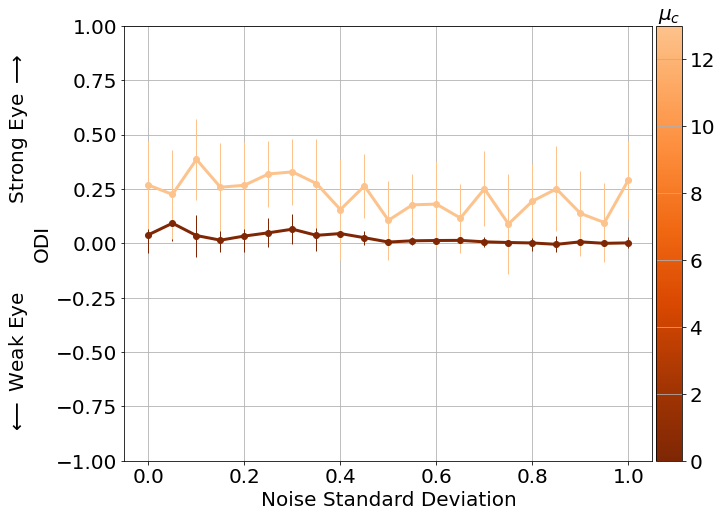

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

Blues2 = truncate_colormap(cm.Blues, 0.3, 1.0).reversed()
Oranges2 = truncate_colormap(cm.Oranges, 0.3, 1.0).reversed()


count=0
v=np.flip(linspace(0.3,1,len(mu_c_mat)))

for mu_count,mu_c in enumerate(mu_c_mat):
    s=Storage()
    for noise_count,open_eye_noise in enumerate(open_eye_noise_mat):
        params=all_params[count]
        count+=1
        R=RR[params.sfname]
        noise=params.noise
        μ,σ=μσ(R.ODI[-1])

        s+=noise,μ,σ
    
    
    noise,μ,σ=s.arrays()
    errorbar(noise,μ,yerr=2*σ,marker='o',elinewidth=1,color=cm.Oranges(v[mu_count]))    
    xlabel('Noise Standard Deviation')
    ylabel(r'$\longleftarrow$ Weak Eye              Strong Eye $\longrightarrow$'+"\nODI")
    ylim([-1,1])

divider = make_axes_locatable(plt.gca())
ax_cb2 = divider.new_horizontal(size="5%", pad=0.05)    
ax_cb2.grid(False)
cb2 = mpl.colorbar.ColorbarBase(ax_cb2, cmap=Oranges2,norm=mpl.colors.Normalize(vmin=mu_c_mat[0], vmax=mu_c_mat[-1]),orientation='vertical')
ax_cb2.grid(True)
plt.gcf().add_axes(ax_cb2)
title(r'$\mu_c$')

#savefig('fig-deficit-ODI-mu_c-blur')

